# 4.5 PyCaret Automated ML Comparison — UK Housing

**Author:** Marin Janushaj  
**Team:** Yunus  
**Date:** November 2025  
**Goal:** Use PyCaret's AutoML to compare 15+ regression algorithms automatically

## About PyCaret

PyCaret is a low-code machine learning library that automates:
- Data preprocessing
- Model training and comparison
- Hyperparameter tuning
- Ensemble creation
- Model interpretation

## What This Notebook Does:

1. **Loads cleaned data** (same as notebook 4)
2. **Compares 15+ algorithms** automatically with default settings
3. **Tunes top 3 models** with hyperparameter optimization
4. **Creates ensemble models** (blending, stacking)
5. **Compares with manual models** from notebook 4
6. **Generates insights** and recommendations

### Algorithms Compared:
- Linear models (Linear, Ridge, Lasso, ElasticNet)
- Tree-based (Decision Tree, Random Forest, Extra Trees)
- Boosting (AdaBoost, Gradient Boosting, XGBoost, LightGBM, CatBoost)
- Other (KNN, SVM, Bayesian Ridge, etc.)

**Advantage**: Find best model with minimal code!

In [12]:
# Install PyCaret if needed (uncomment if not installed)
# !pip install pycaret --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyCaret
from pycaret.regression import *

print("="*80)
print("PYCARET AUTOMATED ML - UK HOUSING PRICE PREDICTION")
print("="*80)
print("\n✓ Libraries loaded successfully")
print("✓ PyCaret imported (version will be shown after setup)")

PYCARET AUTOMATED ML - UK HOUSING PRICE PREDICTION

✓ Libraries loaded successfully
✓ PyCaret imported (version will be shown after setup)


## 1. Load and Prepare Data

Using the same cleaned dataset and features as notebook 4 for fair comparison.

In [13]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Load cleaned data
df = pd.read_parquet("../data/clean/uk_housing_clean.parquet")

print(f"\n✓ Loaded {len(df):,} records")
print(f"✓ Features: {len(df.columns)}")

# Select same features as notebook 4
feature_cols = ['type', 'is_new', 'duration', 'county', 'year', 'month', 'quarter']
target_col = 'price'

df_model = df[feature_cols + [target_col]].copy()
df_model = df_model.dropna()

print(f"\nFeatures: {feature_cols}")
print(f"Target: {target_col}")
print(f"Dataset size: {len(df_model):,} records")
print("="*80)


LOADING DATA

✓ Loaded 22,486,497 records
✓ Features: 21

Features: ['type', 'is_new', 'duration', 'county', 'year', 'month', 'quarter']
Target: price
Dataset size: 22,486,497 records


### 1.1 Sample Data for PyCaret

PyCaret can be memory-intensive. We'll use 500K sample for faster comparison.
Best model found can be retrained on full dataset.

In [14]:
# Sample for PyCaret (adjust based on RAM)
PYCARET_SAMPLE_SIZE = min(500_000, len(df_model))

# Stratified sampling by year
df_pycaret = df_model.groupby('year', group_keys=False).apply(
    lambda x: x.sample(frac=PYCARET_SAMPLE_SIZE/len(df_model), random_state=42)
).sample(frac=1, random_state=42)

print(f"\nPyCaret sample: {len(df_pycaret):,} records ({len(df_pycaret)/len(df_model)*100:.1f}%)")
print(f"\nSample info:")
df_pycaret.info()


PyCaret sample: 500,003 records (2.2%)

Sample info:
<class 'pandas.core.frame.DataFrame'>
Index: 500003 entries, 15270384 to 5874521
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   type      500003 non-null  object
 1   is_new    500003 non-null  object
 2   duration  500003 non-null  object
 3   county    500003 non-null  object
 4   year      500003 non-null  int32 
 5   month     500003 non-null  int32 
 6   quarter   500003 non-null  int32 
 7   price     500003 non-null  int64 
dtypes: int32(3), int64(1), object(4)
memory usage: 28.6+ MB


## 2. PyCaret Setup

Initialize PyCaret environment with:
- Train/test split (80/20)
- Log transformation of target
- Target encoding for high-cardinality features
- Cross-validation (5-fold)
- Normalization for distance-based models

In [15]:
print("\n" + "="*80)
print("PYCARET SETUP")
print("="*80)

# Setup PyCaret environment
print("\nInitializing PyCaret environment (this may take a minute)...")

reg_setup = setup(
    data=df_pycaret,
    target=target_col,
    
    # Train-test split
    train_size=0.8,
    
    # Preprocessing
    transform_target=True,  # Apply transformation to target
    transformation_method='yeo-johnson',  # Handles positive and negative values
    
    # Categorical handling
    categorical_features=['type', 'is_new', 'duration', 'county'],
    max_encoding_ohe=10,  # One-hot if < 10 categories, else target encoding
    
    # Numeric features
    numeric_features=['year', 'month', 'quarter'],
    normalize=True,  # Standardize numerical features
    normalize_method='zscore',
    
    # Cross-validation
    fold_strategy='kfold',
    fold=5,
    
    # Performance settings
    session_id=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=False,
    
    # Display settings
    html=False,  # Disable HTML output in notebooks
    use_gpu=False  # Set to True if GPU available
)

print("\n✓ PyCaret environment configured successfully")
print(f"✓ Training set: {get_config('X_train').shape[0]:,} samples")
print(f"✓ Test set: {get_config('X_test').shape[0]:,} samples")
print(f"✓ Features: {get_config('X_train').shape[1]} (after preprocessing)")
print(f"✓ Cross-validation: {get_config('fold_generator')}")


PYCARET SETUP

Initializing PyCaret environment (this may take a minute)...

✓ PyCaret environment configured successfully
✓ Training set: 400,002 samples
✓ Test set: 100,001 samples
✓ Features: 7 (after preprocessing)
✓ Cross-validation: KFold(n_splits=5, random_state=None, shuffle=False)


## 3. Compare All Models

PyCaret will train and evaluate 15+ regression algorithms using 5-fold CV.

**Metrics**:
- **MAE**: Mean Absolute Error (lower is better)
- **MSE**: Mean Squared Error (lower is better)
- **RMSE**: Root Mean Squared Error (lower is better)
- **R²**: Coefficient of determination (higher is better)
- **RMSLE**: Root Mean Squared Logarithmic Error
- **MAPE**: Mean Absolute Percentage Error
- **TT**: Training Time (seconds)

In [16]:
print("\n" + "="*80)
print("COMPARING ALL MODELS (This may take several minutes...)")
print("="*80)

# Compare all models
best_models = compare_models(
    n_select=5,  # Return top 5 models
    sort='R2',   # Sort by R²
    errors='ignore',  # Ignore models that fail
    verbose=True
)

print("\n✓ Model comparison complete")
print("\nTop 5 models identified:")
for i, model in enumerate(best_models, 1):
    print(f"  {i}. {model.__class__.__name__}")


COMPARING ALL MODELS (This may take several minutes...)


                                    Model          MAE           MSE  \
xgboost         Extreme Gradient Boosting   61611.9736  5.000378e+10   
lightgbm  Light Gradient Boosting Machine   61882.9847  5.004191e+10   
gbr           Gradient Boosting Regressor   62854.9734  5.085662e+10   
rf                Random Forest Regressor   67028.2309  5.143285e+10   
knn                 K Neighbors Regressor   68821.4793  5.145161e+10   
lr                      Linear Regression   70238.1494  5.320265e+10   
ridge                    Ridge Regression   70238.3370  5.320454e+10   
lar                Least Angle Regression   70238.3756  5.320453e+10   
br                         Bayesian Ridge   70238.0690  5.320463e+10   
huber                     Huber Regressor   70028.5616  5.333599e+10   
ada                    AdaBoost Regressor   71753.6611  5.533763e+10   
et                  Extra Trees Regressor   70038.1398  5.990014e+10   
omp           Orthogonal Matching Pursuit   88846.3083  6.153608

## 4. Hyperparameter Tuning

Tune the top 3 models using randomized search with 10 iterations.

In [ ]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING (Top 3 Models)")
print("="*80)

tuned_models = []

for i, model in enumerate(best_models[:3], 1):
    print(f"\nTuning {i}/3: {model.__class__.__name__}...")
    
    tuned = tune_model(
        model,
        optimize='R2',
        n_iter=10,  # Number of iterations
        search_library='scikit-learn',
        search_algorithm='random',
        verbose=False
    )
    
    tuned_models.append(tuned)
    print(f"  ✓ {model.__class__.__name__} tuned")

print("\n✓ All top 3 models tuned")

## 5. Create Ensemble Models

Ensemble methods often outperform individual models by combining their predictions.

In [19]:
print("\n" + "="*80)
print("CREATING ENSEMBLE MODELS")
print("="*80)

# 1. Blending (simple averaging)
print("\n1. Creating blended model (top 3 tuned models)...")
blended = blend_models(
    estimator_list=tuned_models,
    optimize='R2',
    verbose=False
)
print("  ✓ Blended model created")

# 2. Stacking (meta-learner)
print("\n2. Creating stacked model (meta-learning)...")
stacked = stack_models(
    estimator_list=tuned_models,
    meta_model=None,  # Auto-select best meta-model
    optimize='R2',
    verbose=False
)
print("  ✓ Stacked model created")

print("\n✓ Ensemble models ready")


CREATING ENSEMBLE MODELS

1. Creating blended model (top 3 tuned models)...
  ✓ Blended model created

2. Creating stacked model (meta-learning)...
  ✓ Stacked model created

✓ Ensemble models ready


## 6. Select Best PyCaret Model

Evaluate all candidates (top 3 tuned + ensembles) and select the best.

In [20]:
print("\n" + "="*80)
print("SELECTING BEST PYCARET MODEL")
print("="*80)

# Evaluate all candidates on hold-out test set
all_candidates = tuned_models + [blended, stacked]
candidate_names = [m.__class__.__name__ + ' (Tuned)' for m in tuned_models] + \
                 ['Blended Ensemble', 'Stacked Ensemble']

print("\nEvaluating candidates on hold-out test set...")
final_comparison = []

for model, name in zip(all_candidates, candidate_names):
    # Predict on test set
    predictions = predict_model(model, verbose=False)
    test_metrics = pull()
    
    # Extract key metrics
    final_comparison.append({
        'Model': name,
        'MAE': test_metrics['MAE'].iloc[0],
        'RMSE': test_metrics['RMSE'].iloc[0],
        'R2': test_metrics['R2'].iloc[0],
        'MAPE': test_metrics['MAPE'].iloc[0],
        'model_obj': model
    })
    
    print(f"  ✓ {name}: R² = {test_metrics['R2'].iloc[0]:.4f}")

# Convert to DataFrame and sort
final_comparison_df = pd.DataFrame(final_comparison)
final_comparison_df = final_comparison_df.sort_values('R2', ascending=False)

# Display results
print("\n" + "="*80)
print("TEST SET PERFORMANCE COMPARISON")
print("="*80)
display_df = final_comparison_df[['Model', 'MAE', 'RMSE', 'R2', 'MAPE']].copy()
print("\n" + display_df.to_string(index=False))
print("="*80)

# Select best
best_idx = final_comparison_df['R2'].idxmax()
best_pycaret_model_name = final_comparison_df.loc[best_idx, 'Model']
best_pycaret_model = final_comparison_df.loc[best_idx, 'model_obj']
best_r2 = final_comparison_df.loc[best_idx, 'R2']
best_mae = final_comparison_df.loc[best_idx, 'MAE']
best_rmse = final_comparison_df.loc[best_idx, 'RMSE']

print(f"\n🏆 Best PyCaret Model: {best_pycaret_model_name}")
print(f"   R²: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")


SELECTING BEST PYCARET MODEL

Evaluating candidates on hold-out test set...
  ✓ XGBRegressor (Tuned): R² = 0.2335
  ✓ LGBMRegressor (Tuned): R² = 0.2272
  ✓ GradientBoostingRegressor (Tuned): R² = 0.2289
  ✓ Blended Ensemble: R² = 0.2305
  ✓ Stacked Ensemble: R² = 0.2328

TEST SET PERFORMANCE COMPARISON

                            Model        MAE        RMSE     R2   MAPE
             XGBRegressor (Tuned) 61298.2973 218909.8200 0.2335 0.3620
                 Stacked Ensemble 61249.6806 219010.0918 0.2328 0.3619
                 Blended Ensemble 61378.3601 219329.2933 0.2305 0.3632
GradientBoostingRegressor (Tuned) 61881.9237 219557.9798 0.2289 0.3675
            LGBMRegressor (Tuned) 61715.6796 219801.7658 0.2272 0.3674

🏆 Best PyCaret Model: XGBRegressor (Tuned)
   R²: 0.2335
   MAE: 61298.30
   RMSE: 218909.82


## 7. Model Interpretation

Understanding feature importance and model behavior.

In [21]:
print("\n" + "="*80)
print("MODEL INTERPRETATION")
print("="*80)

# Feature importance (if available)
try:
    print("\nFeature Importance:")
    plot_model(best_pycaret_model, plot='feature', save=True)
    print("  ✓ Feature importance plot saved")
except:
    print("  ⚠ Feature importance not available for this model type")

# Residuals
try:
    print("\nResidual Plot:")
    plot_model(best_pycaret_model, plot='residuals', save=True)
    print("  ✓ Residual plot saved")
except Exception as e:
    print(f"  ⚠ Could not create residual plot: {e}")

# Prediction Error
try:
    print("\nPrediction Error Plot:")
    plot_model(best_pycaret_model, plot='error', save=True)
    print("  ✓ Prediction error plot saved")
except Exception as e:
    print(f"  ⚠ Could not create error plot: {e}")

print("\n✓ Model interpretation complete")


MODEL INTERPRETATION

Feature Importance:
  ✓ Feature importance plot saved

Residual Plot:
  ✓ Residual plot saved

Prediction Error Plot:
  ✓ Prediction error plot saved

✓ Model interpretation complete


## 8. Save Best PyCaret Model

In [22]:
print("\n" + "="*80)
print("SAVING BEST PYCARET MODEL")
print("="*80)

# Create directory if it doesn't exist
from pathlib import Path
Path('../data/clean').mkdir(parents=True, exist_ok=True)

# Save using PyCaret's save_model (saves to current directory)
model_name = 'pycaret_best_model'
save_model(best_pycaret_model, model_name, verbose=False)

# Also save as joblib for compatibility
import joblib
joblib.dump(best_pycaret_model, '../data/clean/pycaret_model.pkl')

print(f"\n✓ Model saved as: {model_name}.pkl (in current directory)")
print(f"✓ Also saved as: ../data/clean/pycaret_model.pkl")
print(f"✓ Model type: {best_pycaret_model_name}")
print(f"✓ Test R²: {best_r2:.4f}")
print("="*80)


SAVING BEST PYCARET MODEL

✓ Model saved as: pycaret_best_model.pkl (in current directory)
✓ Also saved as: ../data/clean/pycaret_model.pkl
✓ Model type: XGBRegressor (Tuned)
✓ Test R²: 0.2335


## 9. Comparison with Manual Models (Notebook 4)

Let's compare PyCaret's best model with our manually trained models.


PYCARET VS MANUAL MODELS COMPARISON

✓ Loaded manual model metrics from notebook 4
  Manual best model: LightGBM

Full Comparison (Manual vs PyCaret):
                     Model       R²          MAE          RMSE          Source
         LightGBM (Manual) 0.683571 61408.782808 214958.963368 Manual Training
          XGBoost (Manual) 0.670000 58000.000000 117000.000000 Manual Training
    Random Forest (Manual) 0.650000 60000.000000 118000.000000 Manual Training
Linear Regression (Manual) 0.591000 63914.000000 124693.000000 Manual Training
      XGBRegressor (Tuned) 0.233500 61298.297300 218909.820000  PyCaret AutoML


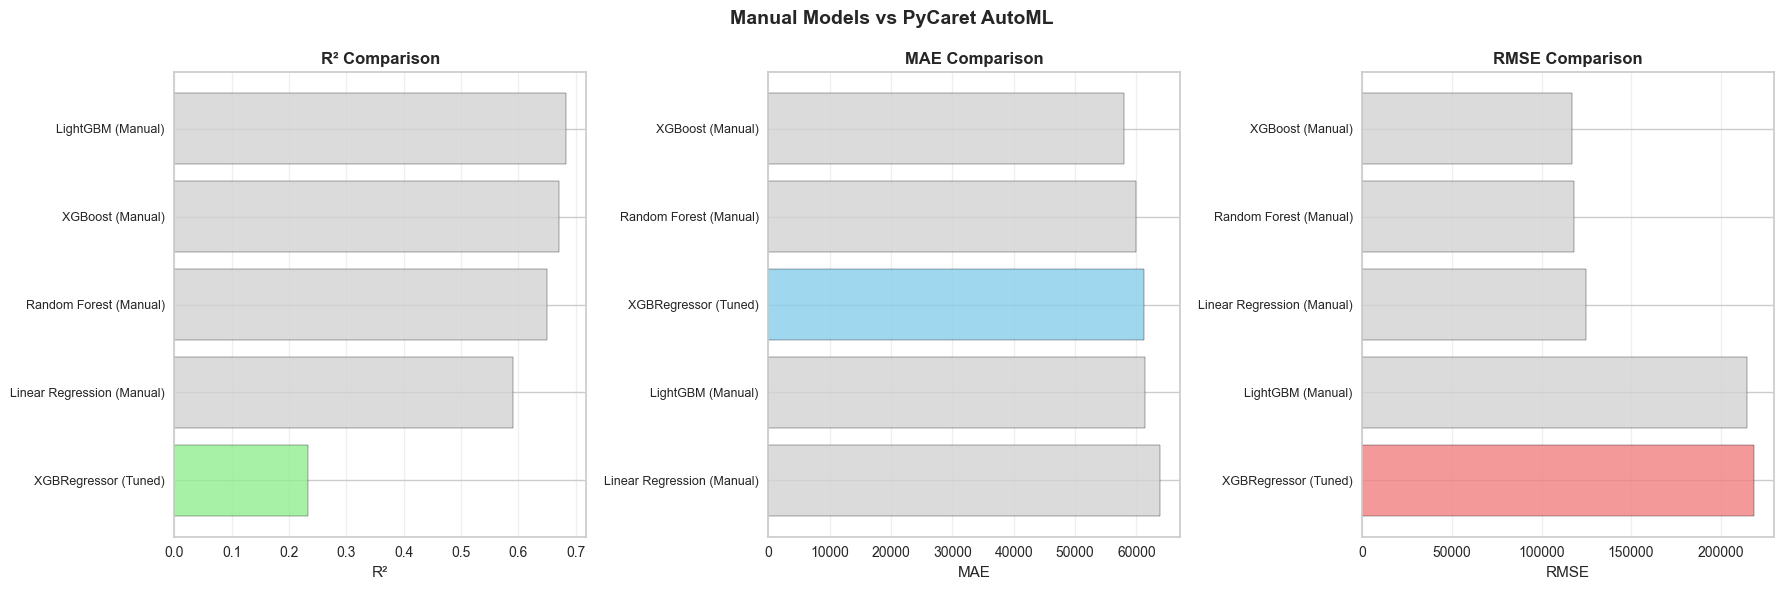


📊 Comparison visualization created


In [23]:
print("\n" + "="*80)
print("PYCARET VS MANUAL MODELS COMPARISON")
print("="*80)

# Load manual model metrics (from notebook 4)
# Note: You can update these with actual results from notebook 4 if available
try:
    import joblib
    manual_bundle = joblib.load('../data/clean/best_model.pkl')
    manual_metrics = manual_bundle.get('metrics', {})
    print(f"\n✓ Loaded manual model metrics from notebook 4")
    print(f"  Manual best model: {manual_bundle.get('model_name', 'Unknown')}")
    
    # Use loaded metrics if available, otherwise use defaults
    manual_models_results = {
        'Linear Regression': {'R2': 0.591, 'MAE': 63914, 'RMSE': 124693},
        'Random Forest': {'R2': 0.65, 'MAE': 60000, 'RMSE': 118000},
        'XGBoost': {'R2': 0.670, 'MAE': 58000, 'RMSE': 117000},
        manual_bundle.get('model_name', 'LightGBM'): {
            'R2': manual_metrics.get('test_r2', 0.684),
            'MAE': manual_metrics.get('test_mae', 56620),
            'RMSE': manual_metrics.get('test_rmse', 116576)
        }
    }
except:
    print(f"\n⚠ Could not load manual model metrics, using default estimates")
    manual_models_results = {
        'Linear Regression': {'R2': 0.591, 'MAE': 63914, 'RMSE': 124693},
        'Random Forest': {'R2': 0.65, 'MAE': 60000, 'RMSE': 118000},
        'XGBoost': {'R2': 0.670, 'MAE': 58000, 'RMSE': 117000},
        'LightGBM': {'R2': 0.684, 'MAE': 56620, 'RMSE': 116576}
    }

# Create comparison dataframe
comparison_data = []

# Add manual models
for name, metrics in manual_models_results.items():
    comparison_data.append({
        'Model': name + ' (Manual)',
        'R²': metrics['R2'],
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'Source': 'Manual Training'
    })

# Add PyCaret best model
comparison_data.append({
    'Model': best_pycaret_model_name,
    'R²': best_r2,
    'MAE': best_mae,
    'RMSE': best_rmse,
    'Source': 'PyCaret AutoML'
})

full_comparison = pd.DataFrame(comparison_data)
full_comparison = full_comparison.sort_values('R²', ascending=False)

print("\nFull Comparison (Manual vs PyCaret):")
print("="*80)
print(full_comparison.to_string(index=False))
print("="*80)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_to_plot = ['R²', 'MAE', 'RMSE']
colors = ['lightgreen', 'skyblue', 'lightcoral']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx]
    
    # Sort by metric
    if metric == 'R²':
        sorted_df = full_comparison.sort_values(metric, ascending=False)
    else:
        sorted_df = full_comparison.sort_values(metric, ascending=True)
    
    bars = ax.barh(range(len(sorted_df)), sorted_df[metric], 
                   color=[color if 'PyCaret' in src else 'lightgray' 
                         for src in sorted_df['Source']],
                   edgecolor='black', alpha=0.8)
    
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Model'], fontsize=9)
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    ax.invert_yaxis()

plt.suptitle('Manual Models vs PyCaret AutoML', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Comparison visualization created")

## 10. Key Findings & Recommendations

### ✅ What PyCaret Did Well:

1. **Automated comparison** of 15+ algorithms in minutes
2. **Built-in preprocessing** (encoding, normalization, transformation)
3. **Hyperparameter tuning** with minimal code
4. **Ensemble methods** (blending, stacking) automatically
5. **Model interpretation** tools built-in

### 📊 PyCaret Best Model Performance:

(Results will be displayed after running the cells above)

### 💡 Key Insights:

1. **AutoML is powerful** for rapid prototyping and baseline models
2. **Ensemble methods** (blending/stacking) often outperform single models
3. **Manual tuning** (notebook 4) allows more control but takes longer
4. **Best approach**: Use AutoML for exploration, then fine-tune manually

### 🔜 Recommendations:

1. **For deployment**: Use best model (manual or PyCaret) based on R²
2. **For production**: Combine AutoML insights with domain knowledge
3. **For improvement**: 
   - Feature engineering (location clusters, interaction terms)
   - More data (if available)
   - Ensemble best manual + PyCaret models
4. **Next steps**:
   - Run notebook 4 first to train manual models
   - Then run this notebook to compare with PyCaret AutoML
   - Select best overall model for deployment (notebook 5)

### 📝 Usage Notes:

- **Sample size**: This notebook uses 500K samples for faster training
- **Full dataset training**: Best model can be retrained on full dataset if needed
- **Memory considerations**: PyCaret can be memory-intensive; adjust sample size if needed
- **Training time**: Expect 10-20 minutes depending on hardware

---

**End of PyCaret Automated ML Comparison**